In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("..")

from gob.benchmarks import *
from gob.optimizers import *
import matplotlib
matplotlib.rcParams.update({"text.usetex": True})

In [2]:
class MinWrapper:
  def __init__(self, func):
    self.func = func
    self.visual_bounds = func.visual_bounds
    self.values = []
  
  def __call__(self, x):
    y = self.func(x)
    self.values.append(y)
    return y
  
  def get_min_per_iteration(self, n_particles):
    mins = []
    for i in range(len(self.values) // n_particles + 1):
      prev_min = mins[-1] if mins else float("inf")
      actual_min = np.min(self.values[i * n_particles : (i + 1) * n_particles])
      mins.append(min(prev_min, actual_min))
    return mins

class MinWrapperGrad:
  def __init__(self, func):
    self.func = func
    self.visual_bounds = func.visual_bounds
    self.values = []
    self.prev_sample = None
  
  def __call__(self, x):
    y = self.func(x)
    if self.prev_sample is None or not np.all(np.abs(x - self.prev_sample) <= 2e-9):
      self.values.append(y)
    self.prev_sample = x
    return y
  
  def get_min_per_iteration(self, n_particles):
    mins = []
    for i in range(len(self.values) // n_particles):
      prev_min = mins[-1] if mins else float("inf")
      actual_min = np.min(self.values[i * n_particles : (i + 1) * n_particles])
      mins.append(min(prev_min, actual_min))
    return mins

In [3]:
g = Ackley()
dim = 8
bounds = augment_dimensions(g.visual_bounds, dim)
n_particles = 300
iter = 1000
verbose = False
wrapper = MinWrapper
alg = CBO
cn_alg = CN_CBO

In [4]:
f = wrapper(g)

opt = alg(bounds=bounds, n_particles=n_particles, iter=iter, verbose=verbose)
res = opt.minimize(f)
print(f"Results for {opt}: {res[1]}")
mins = f.get_min_per_iteration(n_particles)

Results for CBO: 16.289291653474905


In [5]:
f = wrapper(g)

opt = cn_alg(bounds=bounds, n_particles=n_particles, iter=iter, verbose=verbose, moment="M1")
res = opt.minimize(f)
print(f"Results for {opt}: {res[1]}")
mins_m1 = f.get_min_per_iteration(n_particles)

Results for CN-CBO: 1.133166570583747


In [6]:
f = wrapper(g)

opt = cn_alg(bounds=bounds, n_particles=n_particles, iter=iter, verbose=verbose, moment="M2")
res = opt.minimize(f)
print(f"Results for {opt}: {res[1]}")
mins_m2 = f.get_min_per_iteration(n_particles)

Results for CN-CBO: 0.19157732309429365


In [7]:
f = wrapper(g)

opt = cn_alg(bounds=bounds, n_particles=n_particles, iter=iter, verbose=verbose, moment="VAR")
res = opt.minimize(f)
print(f"Results for {opt}: {res[1]}")
mins_var = f.get_min_per_iteration(n_particles)

Results for CN-CBO: 0.39266705362699783


In [8]:
f = wrapper(g)

opt = cn_alg(bounds=bounds, n_particles=n_particles, iter=iter, verbose=verbose, moment="MVAR")
res = opt.minimize(f)
print(f"Results for {opt}: {res[1]}")
mins_mvar = f.get_min_per_iteration(n_particles)

Results for CN-CBO: 1.0936536705495468


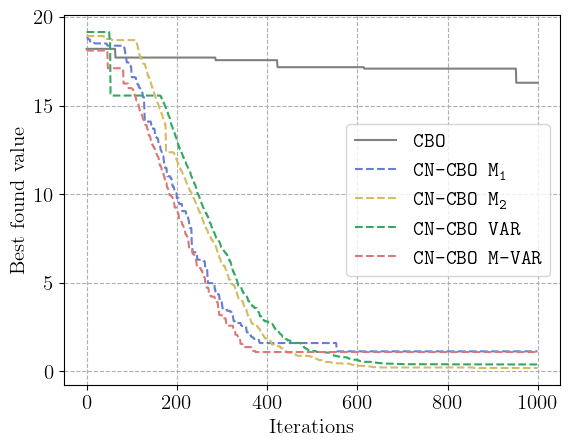

In [9]:
alg_name = str(alg([]))
cn_alg_name = str(cn_alg([]))

latex_label = lambda s: r"\texttt{" + s.replace("_", r"\_") + "}"
c1 = "#657ed4"
c2 = "#d4bb65"
c3 = "#32a861"
c4 = "#dd7878"

plt.rcParams.update({"font.size": 15})

plt.plot(mins[:iter], label=latex_label(alg_name), linestyle="-", color="gray")
plt.plot(mins_m1[:iter], label=latex_label(f"{cn_alg_name} M" + r"\textsubscript{1}"), linestyle="--", c=c1)
plt.plot(mins_m2[:iter], label=latex_label(f"{cn_alg_name} M" + r"\textsubscript{2}"), linestyle="--", c=c2)
plt.plot(mins_var[:iter], label=latex_label(f"{cn_alg_name} VAR"), linestyle="--", c=c3)
plt.plot(mins_mvar[:iter], label=latex_label(f"{cn_alg_name} M-VAR"), linestyle="--", c=c4)

plt.xlabel(r"$\textrm{Iterations}$")
plt.ylabel(r"$\textrm{Best found value}$")
plt.grid(linestyle="--")
plt.legend()
plt.savefig(f"impact_noise_{alg_name.lower()}.pdf", bbox_inches="tight")